In [50]:
! ddm-dataset nlink --prefix 003 --num 100 --train_num 90 --nlink_n 1 --nlink_q0 --T 10 --dh 0.05 --input_type_id 5 --without_normalization --input_scale 5

> T= 10.0  dh= 0.05
> intput ID: 5
> nlink: 1
> input_scale: 5.0
[SAVE] dataset/003nlink.info.json
[SAVE] dataset/003nlink.train.obs.npy
(90, 200, 1)
[SAVE] dataset/003nlink.test.obs.npy
(10, 200, 1)
[SAVE] dataset/003nlink.train.input.npy
(90, 200, 1)
[SAVE] dataset/003nlink.test.input.npy
(10, 200, 1)
[SAVE] dataset/003nlink.train.state.npy
(90, 200, 2)
[SAVE] dataset/003nlink.test.state.npy
(10, 200, 2)
[SAVE] dataset/003nlink.train.stable.npy
(90, 200, 1)
[SAVE] dataset/003nlink.test.stable.npy
(10, 200, 1)


In [51]:
import ddm.util_data
from ddm.util_data import DiosDataset

target_data=ddm.util_data.load_all_data("dataset/003nlink.test",{})
print("obs:",target_data.obs.shape)
print("input:",target_data.input.shape)
print("state:",target_data.state.shape)
x=target_data.state
y=target_data.obs
u=target_data.input

obs: (10, 200, 1)
input: (10, 200, 1)
state: (10, 200, 2)


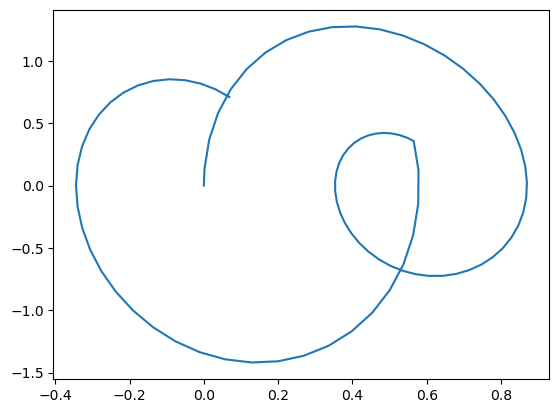

In [54]:
import matplotlib.pyplot as plt

idx=2
plt.plot(x[idx,:,0],x[idx,:,1])

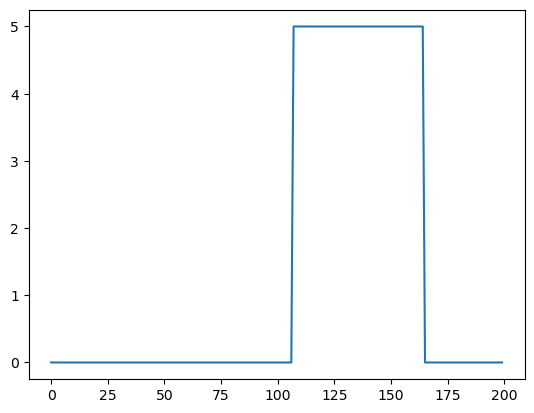

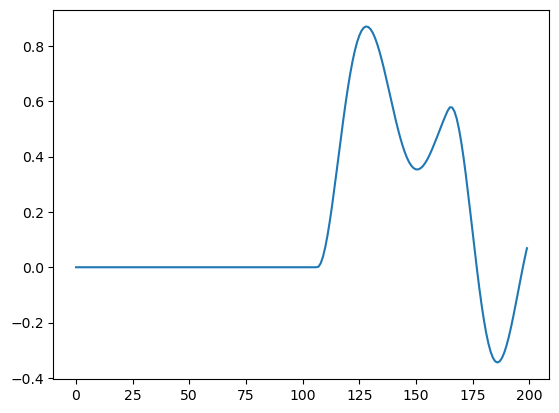

In [55]:
plt.plot(u[idx,:,0])
plt.show()
plt.plot(y[idx,:,0])
plt.show()


In [45]:
from ddm.trainer import SystemTrainer
from ddm.model import NeuralDissipativeSystem
from omegaconf import OmegaConf
config_path="result/config.yaml"
config = OmegaConf.load(config_path)

device="cpu"
model=NeuralDissipativeSystem(config=config,device=device)
trainer=SystemTrainer(config=config,model=model,device=device)

path="result/model/best.checkpoint"
trainer.load_ckpt(path)

In [10]:
import torch
import numpy as np
Q=torch.tensor(-np.eye(model.obs_dim),dtype=torch.float32)
R=torch.tensor(np.eye(model.in_dim),dtype=torch.float32)
S=torch.tensor(np.zeros((model.obs_dim,model.in_dim)),dtype=torch.float32)
Q, R, S=Q.to(device), R.to(device), S.to(device)
trainer.model.set_dissipative(Q,R,S)

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
import numpy as np
import torch
def get_grid_data(min_v, max_v, delta):
  x1 = np.arange(min_v, max_v, delta)
  x2 = np.arange(min_v, max_v, delta)
  xx = np.meshgrid(x1,x2)
  x_grid_data=np.transpose(np.reshape(np.array(xx),(2,-1)))
  ###
  n=len(x1)
  i1 = np.arange(n)
  i2 = np.arange(n)
  ii = np.meshgrid(i1,i2)
  i_grid_data = np.transpose(np.reshape(np.array(ii),(2,-1)))
  conter_x=(x1,x2)
  return x_grid_data, i_grid_data, conter_x, n


In [17]:
min_v=-1.5
max_v=1.5
delta=0.1

x_grid_data, i_grid_data, conter_x, n = get_grid_data(min_v, max_v, delta)
x_grid_data

x=torch.tensor(x_grid_data,dtype=torch.float32,device=device)
#fx_new, gx_new, jx_mat, hx, fx_diff, gx_diff, _ =trainer.model.forward_proj(x)
fx_new=trainer.model.f_nn(x)


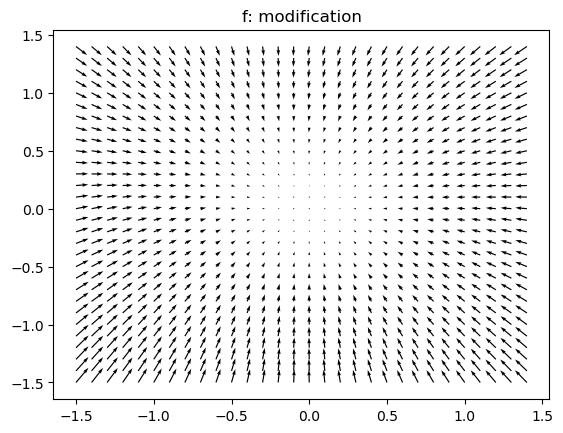

In [18]:
f_modify_=fx_new.detach().cpu().numpy()/10.0
plt.quiver(x_grid_data[:,0],x_grid_data[:,1],f_modify_[:,0],f_modify_[:,1])

#CS=plt.contour(conter_x[0],conter_x[1],Z,levels=30)
#plt.clabel(CS, inline=True)
plt.title("f: modification")
plt.show()


In [21]:
hx_new=trainer.model.h_nn(x)


In [23]:
hx_new

tensor([[-2.3705,  0.9714],
        [-2.2888,  0.9901],
        [-2.2189,  1.0011],
        ...,
        [ 0.7971,  2.1301],
        [ 0.8705,  2.3267],
        [ 0.9234,  2.5142]], grad_fn=<AddBackward0>)

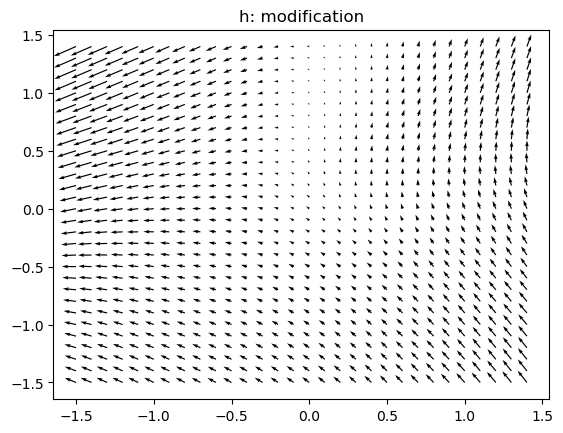

In [29]:
f_modify_=hx_new.detach().cpu().numpy()/10.0
plt.quiver(x_grid_data[:,0],x_grid_data[:,1],f_modify_[:,0],f_modify_[:,1])

#CS=plt.contour(conter_x[0],conter_x[1],Z,levels=30)
#plt.clabel(CS, inline=True)
plt.title("h: modification")
plt.show()


In [47]:
in_dim=1
state_dim=2
dt_u=torch.tensor(0.01)
t_u=torch.arange(0,1,dt_u)
batch_size=10
u=torch.zeros((len(t_u),batch_size,in_dim))
u[t_u<0.25,:,:]=1.0
u[t_u<0.05,:,:]=0.0
t=torch.arange(0,10,0.01)

x0=torch.normal(torch.zeros((batch_size,state_dim)),1)
x0=x0.to(device)
u=torch.tensor(u).to(device)
t=t.to(device)
dt_u=dt_u.to(device)
t=torch.arange(0,10,0.01)

#
y,x_sol=trainer.model(x0,u,dt_u,t)
print("x_sol",x_sol.shape)
print("y",y.shape)
print("u",u.shape)

/tmp/ipykernel_3918312/3074063242.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u=torch.tensor(u).to(device)


x_sol torch.Size([1000, 10, 2])
y torch.Size([1000, 10, 2])
u torch.Size([101, 10, 1])


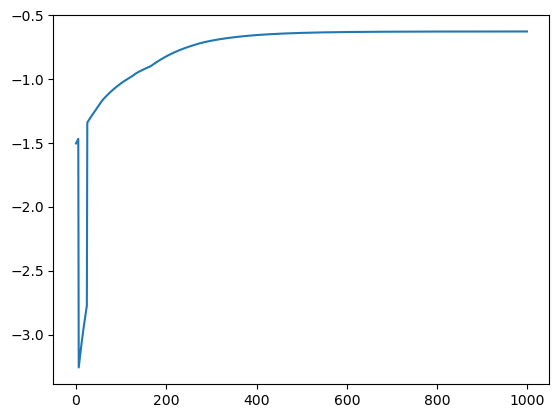

In [49]:
plt.plot(y.detach().numpy()[:,1,0])